# MTA Subway Hourly Ridership: 2020-2024

**Imports**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import folium
from folium.plugins import HeatMap

**Loading data**

In [38]:
# Importing dataset
url = 'https://data.ny.gov/resource/wujg-7c2s.csv'
df = pd.read_csv(url)

# Display the first few rows of the dataset
print(df.head())

         transit_timestamp transit_mode  station_complex_id  \
0  2022-05-10T00:00:00.000       subway                 359   
1  2022-05-10T11:00:00.000       subway                 395   
2  2022-05-10T19:00:00.000       subway                 125   
3  2022-05-10T12:00:00.000       subway                 162   
4  2022-05-10T05:00:00.000       subway                 192   

                      station_complex    borough payment_method  \
0  Flatbush Av-Brooklyn College (2,5)   Brooklyn      metrocard   
1                          103 St (6)  Manhattan      metrocard   
2                       Morgan Av (L)   Brooklyn      metrocard   
3                         50 St (C,E)  Manhattan      metrocard   
4                   Rockaway Blvd (A)     Queens      metrocard   

                fare_class_category  ridership  transfers   latitude  \
0             Metrocard - Full Fare        6.0        1.0  40.632835   
1             Metrocard - Full Fare       78.0        1.0  40.790600   
2 

### Creating plots

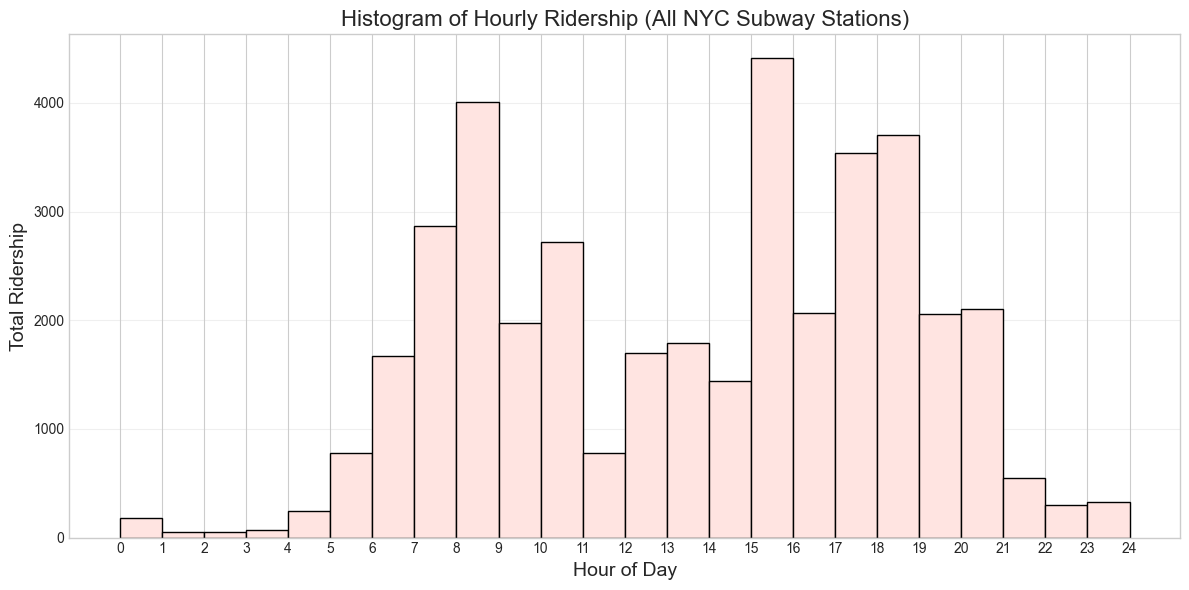

In [39]:
# Convert timestamp to datetime and extract hour
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'], errors='coerce')
df = df.dropna(subset=['transit_timestamp', 'ridership'])  # drop rows with missing timestamps or ridership
df['hour'] = df['transit_timestamp'].dt.hour

# Plot histogram of hourly ridership
plt.figure(figsize=(12, 6))
#sns.histplot(
#    data=df, 
    #x='hour',
#    x=df['hour'].to_numpy(), 
    #weights='ridership',  # weight each entry by its ridership count
#    weights=df['ridership'].to_numpy(),
    #bins=24,
#    bins=np.arange(0, 25, 1), # Makes sure there is one block for each hour 
#    kde=False, 
#    color='mistyrose',
#    edgecolor='black'
#)

plt.hist(
    df['hour'], 
    bins=np.arange(0, 25, 1), 
    weights=df['ridership'], 
    color='mistyrose',
    edgecolor='black'
)

plt.title('Histogram of Hourly Ridership (All NYC Subway Stations)', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Ridership', fontsize=14)
plt.xticks(range(0, 25))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
# Drop rows with missing borough or ridership
df = df.dropna(subset=['borough', 'ridership'])

# Aggregate total ridership per borough
borough_usage = df.groupby('borough')['ridership'].sum().reset_index()

# Sort by ridership for cleaner plotting
borough_usage = borough_usage.sort_values(by='ridership', ascending=False)

# Make sure Staten Island is included (if it's not already in the data)
if 'Staten Island' not in borough_usage['borough'].values:
    # Add Staten Island with a placeholder value if you have one
    # or remove this if-block if you're sure Staten Island is in your dataset
    borough_usage = borough_usage.append({'borough': 'Staten Island', 'ridership': 0}, ignore_index=True)
    borough_usage = borough_usage.sort_values(by='ridership', ascending=False)

# Set the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=borough_usage, x='borough', y='ridership', alpha=0.9)

# Format
plt.title('NYC Subway Ridership by Borough', fontsize=18)
plt.ylabel('Total Ridership', fontsize=14)
plt.xlabel('Borough', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Add value labels directly above the borough names (at the top of the axes)
for i, row in borough_usage.iterrows():
    # Place text at position i (x-axis) and just above 0 on y-axis
    ax.text(i, 0, f"{int(row['ridership']):,}", 
            ha='center', va='bottom', fontsize=10, fontweight='bold',
            color='black', transform=ax.get_xaxis_transform())

plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'append'

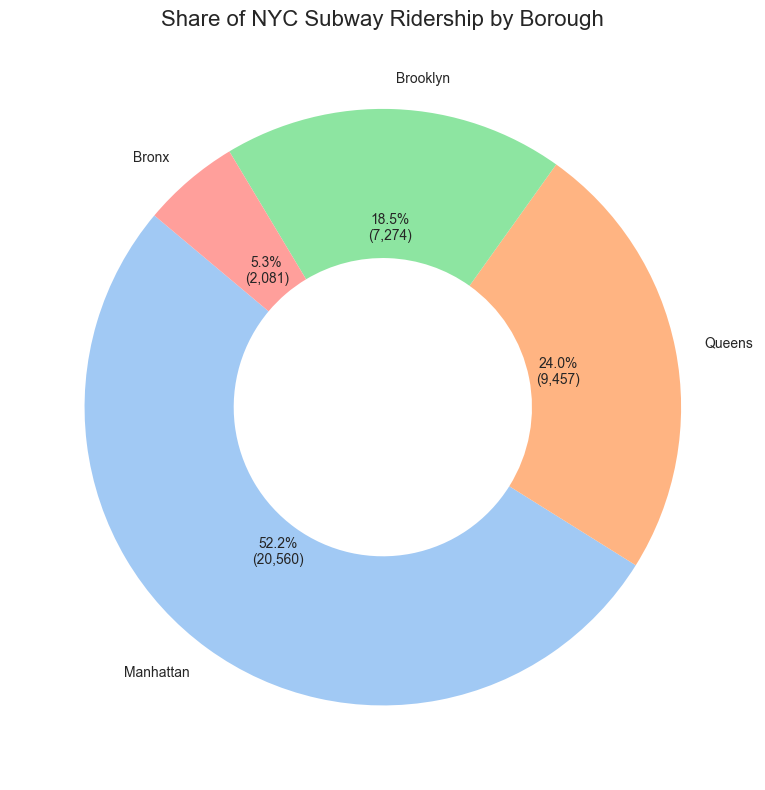

In [41]:
# Pie chart version
plt.figure(figsize=(8, 8))
colors = sns.color_palette("pastel")

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count:,})"  # tilføj tusindtalsseparator
    return my_autopct

plt.pie(borough_usage['ridership'], labels=borough_usage['borough'], 
        autopct=make_autopct(borough_usage['ridership']), startangle=140, colors=colors, 
        wedgeprops=dict(width=0.5))  # Makes a donut chart

plt.title('Share of NYC Subway Ridership by Borough', fontsize=16)
plt.tight_layout()
plt.show()


## Creating Heatmap

In [ ]:
# Drop missing or invalid rows
df = df.dropna(subset=['latitude', 'longitude', 'ridership'])

# Optional: filter to remove weird outlier entries (e.g., zero or negative ridership)
df = df[df['ridership'] > 0]

# Aggregate ridership by station location
station_usage = df.groupby(['latitude', 'longitude']).agg(
    total_ridership=('ridership', 'sum')
).reset_index()

# Scale the ridership for display (adjust divisor if needed)
station_usage['weight'] = station_usage['total_ridership'] / 1000

# Convert to list of [lat, lon, weight]
heat_data = station_usage[['latitude', 'longitude', 'weight']].values.tolist()

# NYC coordinates
nyc_latitude = 40.7128
nyc_longitude = -74.0060

# Create a folium map centered on NYC
nyc_map = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

# Add heatmap layer
HeatMap(heat_data, radius=10, blur=8, max_zoom=1).add_to(nyc_map)

# Display map in notebook (for Jupyter / Colab)
nyc_map


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the dataset
url = 'https://data.ny.gov/resource/wujg-7c2s.csv'
print("Loading NYC MTA subway data (this may take a moment)...")
df = pd.read_csv(url)

# Drop missing or invalid rows
df = df.dropna(subset=['latitude', 'longitude', 'ridership'])

# Optional: filter to remove weird outlier entries (e.g., zero or negative ridership)
df = df[df['ridership'] > 0]

# Aggregate ridership by station location
station_usage = df.groupby(['latitude', 'longitude']).agg(
    total_ridership=('ridership', 'sum')
).reset_index()

# Scale the ridership for display (adjust divisor if needed)
station_usage['weight'] = station_usage['total_ridership'] / 1000

# Convert to list of [lat, lon, weight]
heat_data = station_usage[['latitude', 'longitude', 'weight']].values.tolist()

# NYC coordinates
nyc_latitude = 40.7128
nyc_longitude = -74.0060

# Create a folium map centered on NYC
nyc_map = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

for _, row in station_usage.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        popup=f"Ridership: {int(row['total_ridership'])}",
        fill=True,
        color='blue',
        fill_opacity=0.6
    ).add_to(nyc_map)

# Add heatmap layer
HeatMap(heat_data, radius=10, blur=8, max_zoom=1).add_to(nyc_map)


# Display map in notebook (for Jupyter / Colab)
nyc_map



Loading NYC MTA subway data (this may take a moment)...
